# Content-Based Recommendation Using User Rated Content

In [1]:
import pandas as pd
import pickle as pickle
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from html import unescape
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

In [2]:
data = pd.read_pickle('data_nov_8.pkl')

###### To get Unique user-item pair
explode description as it is list of single entry


In [3]:
df2 = data[['title', 'overall', 'category', 'description', 'asin', 'reviewerID', 'brand', 'price']].explode("description").drop_duplicates(subset=["reviewerID", "asin"])
df2.reset_index(drop=True, inplace=True)


In [4]:
len(df2['reviewerID'].unique())

815053

create category_str column from list type column 'category', with comma separated categories

In [5]:
category_values=[]
for val in data['category']:
    category_values.append(val)

In [6]:
#remove &amp from category values
for row in category_values:
    for i in range (0,len(row)):
        row[i]=row[i].replace('&amp;','and').replace('&', 'and').replace('$amp', 'and')

In [7]:
df2['price'] = df2['price'].apply(lambda row: float(str(row).replace('$','').replace(',', '').replace(' ', '')))

In [8]:
df2['category_str'] = [','.join(map(str, l)) for l in df2['category']]

In [9]:
df2.shape

(965074, 9)

In [10]:
df2.head(10)

,title,overall,category,description,asin,reviewerID,brand,price,category_str
0,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",4.0,"[Electronics, Accessories and Supplies, Audio ...",The videosecu TV mount is a mounting solution ...,0972683275,A1KECIKIWDB4HH,VideoSecu,34.99,"Electronics,Accessories and Supplies,Audio and..."
1,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",5.0,"[Electronics, Accessories and Supplies, Audio ...",The videosecu TV mount is a mounting solution ...,0972683275,A2MQ47BBL7F6B6,VideoSecu,34.99,"Electronics,Accessories and Supplies,Audio and..."
2,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",5.0,"[Electronics, Accessories and Supplies, Audio ...",The videosecu TV mount is a mounting solution ...,0972683275,ANWW7PT6Z6MHD,VideoSecu,34.99,"Electronics,Accessories and Supplies,Audio and..."
3,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",5.0,"[Electronics, Accessories and Supplies, Audio ...",The videosecu TV mount is a mounting solution ...,0972683275,A2DEU0B3AUINV9,VideoSecu,34.99,"Electronics,Accessories and Supplies,Audio and..."
4,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",4.0,"[Electronics, Accessories and Supplies, Audio ...",The videosecu TV mount is a mounting solution ...,0972683275,AE8R1JSMJYIU,VideoSecu,34.99,"Electronics,Accessories and Supplies,Audio and..."
5,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",4.0,"[Electronics, Accessories and Supplies, Audio ...",The videosecu TV mount is a mounting solution ...,0972683275,AQCEXDZDNVJUG,VideoSecu,34.99,"Electronics,Accessories and Supplies,Audio and..."
6,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",4.0,"[Electronics, Accessories and Supplies, Audio ...",The videosecu TV mount is a mounting solution ...,0972683275,A3AKVALGT4Y02G,VideoSecu,34.99,"Electronics,Accessories and Supplies,Audio and..."
7,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",3.0,"[Electronics, Accessories and Supplies, Audio ...",The videosecu TV mount is a mounting solution ...,0972683275,AGDAA8RUL1RWB,VideoSecu,34.99,"Electronics,Accessories and Supplies,Audio and..."
8,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",4.0,"[Electronics, Accessories and Supplies, Audio ...",The videosecu TV mount is a mounting solution ...,0972683275,A2NY5V6HLQWNZB,VideoSecu,34.99,"Electronics,Accessories and Supplies,Audio and..."
9,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",5.0,"[Electronics, Accessories and Supplies, Audio ...",The videosecu TV mount is a mounting solution ...,0972683275,AD491FXTF1SNI,VideoSecu,34.99,"Electronics,Accessories and Supplies,Audio and..."


In [11]:
tf_corpus = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')

### Item Profile
###### combine the attributes providing description of the items (to be vectorized using TF-IDF)

In [21]:
# add description later

In [12]:
df2['corpus'] = pd.Series(df2[['category_str', 'description', 'brand', 'price']].fillna('').values.tolist()).apply(lambda x: ','.join(map(str, x)))
item_df = df2.drop_duplicates(subset=["asin"])


In [13]:
item_df['corpus'][0]

'Electronics,Accessories and Supplies,Audio and Video Accessories,TV Accessories and Parts,TV Ceiling and Wall Mounts,The videosecu TV mount is a mounting solution for most 22"-47" LCD LED Plasma TV and some LED up to 55" with VESA 600x400mm (24"x16"), 400x400mm (16"x16"),600x300mm(24"x12"), 400x200mm (16"x8"),300x300mm (12"x12"),300x200mm(12"x8"),200x200mm (8"x8"),200x100mm (8"x4") mounting hole pattern .Heavy gauge steel construction provides safety loading up to 66lbs display .It can tilt 15 degree forward or backward and swivel 180 degree. The removable VESA plate can be taken off for easy installation. Post-installation level adjustment allows the TV to perfectly level. The on arm cable management ring system design, guides wires and prevent cable pinching. Standard hardware and user manual included. <br />Notice: This mount fits most 22-47" TVs (VESA 200x200mm (8x8")/200x100mm(8x4")/100x100mm(4x4") without extender, fits VESA 600x400(24x16")/400x400mm(16x16")/600x300mm(24x12")/40

In [14]:
item_df.head(1)

,title,overall,category,description,asin,reviewerID,brand,price,category_str,corpus
0,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",4.0,"[Electronics, Accessories and Supplies, Audio ...",The videosecu TV mount is a mounting solution ...,0972683275,A1KECIKIWDB4HH,VideoSecu,34.99,"Electronics,Accessories and Supplies,Audio and...","Electronics,Accessories and Supplies,Audio and..."


In [15]:
tfid_matrix_corpus=tf_corpus.fit_transform(item_df['corpus'])

### User Profile

In [16]:
user_group_df = df2.groupby('reviewerID', as_index=False)['category_str', 'description','brand','price'].agg(lambda row: list(row))
user_group_df['corpus'] = pd.Series(user_group_df[['category_str', 'description','brand','price']].fillna('').values.tolist()).apply(lambda row: ','.join(map(str,[sitem for item in row for sitem in item])))


/var/folders/nd/n16_t_0d3m3dr2cqfzym1czm0000gn/T/ipykernel_23769/3894469562.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_group_df = df2.groupby('reviewerID', as_index=False)['category_str','brand','price'].agg(lambda row: list(row))


In [17]:
user_group_df.head(1)

,reviewerID,category_str,description,brand,price,corpus
0,A0219337RHNC3U3T12TP,"[Electronics,Accessories and Supplies,Audio an...",[Premium 50 Foot High Speed HDMI Cable for you...,[A Days Tech],[11.99],"Electronics,Accessories and Supplies,Audio and..."


In [18]:
tfuid_matrix_corpus=tf_corpus.transform(user_group_df['corpus'])

In [19]:
cosine_similarities_corpus=linear_kernel(tfuid_matrix_corpus,tfid_matrix_corpus)

In [20]:
cosine_similarities_corpus

array([[0.18852634, 0.0083847 , 0.01193411, ..., 0.00853624, 0.08396877,
        0.00866367],
       [1.        , 0.00983016, 0.0145995 , ..., 0.01000783, 0.01916488,
        0.01015722],
       [0.2464739 , 0.01257064, 0.01789204, ..., 0.01279784, 0.07468798,
        0.01298888],
       ...,
       [0.18852634, 0.0083847 , 0.01193411, ..., 0.00853624, 0.08396877,
        0.00866367],
       [0.02048877, 0.03670506, 0.10043684, ..., 0.06289292, 0.27123897,
        0.06383177],
       [0.02349154, 0.04208443, 0.11515654, ..., 0.07211029, 0.28337831,
        0.07318675]])

In [21]:
print(user_group_df['corpus'][0])
print('\n', tfuid_matrix_corpus.data)
print('\n', item_df['corpus'][0])
print('\n', tfid_matrix_corpus.data)

Electronics,Accessories and Supplies,Audio and Video Accessories,Cables and Interconnects,Video Cables,HDMI Cables,Premium 50 Foot High Speed HDMI Cable for your Sony Bravia KDL-40EX400 HDTV ! Supports: 1080p-2160p, 4K, 3D, Deep Color, TrueHD, CL3, and 800Hz technologies.,A Days Tech,11.99

 [0.09895639 0.0918017  0.08625209 ... 0.03348263 0.04770469 0.09285144]

 Electronics,Accessories and Supplies,Audio and Video Accessories,TV Accessories and Parts,TV Ceiling and Wall Mounts,The videosecu TV mount is a mounting solution for most 22"-47" LCD LED Plasma TV and some LED up to 55" with VESA 600x400mm (24"x16"), 400x400mm (16"x16"),600x300mm(24"x12"), 400x200mm (16"x8"),300x300mm (12"x12"),300x200mm(12"x8"),200x200mm (8"x8"),200x100mm (8"x4") mounting hole pattern .Heavy gauge steel construction provides safety loading up to 66lbs display .It can tilt 15 degree forward or backward and swivel 180 degree. The removable VESA plate can be taken off for easy installation. Post-installation l

### Get Recommendation

###### Sort the cosine similarities in descending order 

In [22]:
#######computation for cosimilarity based on corpus#####
consine_similarity_corpus_sorted=[]
results_corpus = {}
for idx, row in df2.iterrows():
    if idx < len(cosine_similarities_corpus):
        similar_indices = cosine_similarities_corpus[idx].argsort()[::-1][:5]
        x = []
        for i in similar_indices:
            x.append((cosine_similarities_corpus[idx][i], item_df.index[i]))
        consine_similarity_corpus_sorted = x
        results_corpus[row['reviewerID']] = consine_similarity_corpus_sorted
results_corpus['A1EJKPTGO474WN']


[(1.0000000000000002, 5170),
 (0.6855795580224974, 5777),
 (0.3116618658564585, 5705),
 (0.31075355144849126, 5814),
 (0.2574970469198158, 3506)]

In [23]:
def item_id_match(id):
    return df2.loc[df2.index == id]['title'].tolist()[0]

# Just reads the results out of the dictionary.def
def recommend(res, user, num):
    print("Recommending " + str(num) + " products for user " + user)
    recs = res[user][:num]
    print("With Score")
    for rec in recs:
        print(rec[0])
    indexes = [rec[1] for rec in recs]
    return df2.iloc[indexes]

In [24]:
df2[df2['reviewerID']=='A2OOXVZ6B1VZ9A'][['title', 'category_str', 'description', 'asin', 'brand', 'price']]

,title,category_str,description,asin,brand,price
7799,Belkin Pro Series USB Device Cable 16 Feet,"Electronics,Computers and Accessories,Computer...",The Hi-Speed USB 2.0 cable helps you achieve m...,B00004Z5PY,Belkin,10.79
9995,"Antec Cyclone Blower, Expansion Slot Cooling Fan","Electronics,Computers and Accessories,Computer...",Cyclone blower - exhaust fan.,B000051299,Antec,9.38


In [25]:
recommend(results_corpus, user='A2OOXVZ6B1VZ9A', num=5)[['title', 'category_str', 'description', 'asin', 'brand', 'price']]


Recommending 5 products for user A2OOXVZ6B1VZ9A
With Score
0.9999999999999999
0.8254093943680548
0.5799295978608917
0.36249459879486007
0.31615803729838554


,title,category_str,description,asin,brand,price
9011,StarTech.com Expansion Slot Rear Exhaust Cooli...,"Electronics,Computers and Accessories,Computer...",This high quality PCI Fan is an add-in cooling...,B0000510SS,StarTech,10.32
8850,StarTech.com 80x25mm Dual Ball Bearing Compute...,"Electronics,Computers and Accessories,Computer...",This versatile PC case fan measures 8cm x 8cm ...,B000050ZTQ,StarTech,8.81
9767,"Antec Cyclone Blower, Expansion Slot Cooling Fan","Electronics,Computers and Accessories,Computer...",Cyclone blower - exhaust fan.,B000051299,Antec,9.38
9601,Startech 10/100Mbps PCI Fast Enet Network Card,"Electronics,Computers and Accessories,Computer...",This 1 Port PCI Fast Ethernet Network Adapter ...,B00005125T,StarTech,9.06
4880,D-Link DFE-530TX+ 10/100 Fast Ethernet Desktop...,"Electronics,Computers and Accessories,Computer...",D-Link DFE-530TX+ 10/100 Fast Ethernet Desktop...,B00004SYNX,D-Link,12.99


## Evaluation


##### normalise similarity score between 1 and 5

In [26]:
min_max_scalar = MinMaxScaler(feature_range=(1, 5))
min_max_scalar.fit(cosine_similarities_corpus)
rating_pred_matrix = min_max_scalar.transform(cosine_similarities_corpus)
rating_pred_df = pd.DataFrame(rating_pred_matrix)
rating_pred_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,1.726949,1.022184,1.038364,5.000000,4.194864,1.489664,1.351710,1.053380,1.397990,1.403085,...,1.019845,1.456339,1.018716,1.988421,1.340096,1.321725,1.212206,1.022586,1.324460,1.022924
1,5.000000,1.027982,1.049050,1.730970,1.665415,1.434452,1.325914,1.068250,1.079040,1.367854,...,1.025032,1.068826,1.023608,1.823341,1.067542,1.063894,1.189867,1.028490,1.064437,1.028916
2,1.960678,1.038976,1.062252,2.776420,2.764572,1.569123,1.533954,1.161392,1.438905,1.476952,...,1.034866,1.361647,1.032882,2.418871,1.301062,1.284800,1.322513,1.039682,1.287221,1.040276
3,1.056517,1.148872,1.428993,1.485370,1.482133,1.054180,1.089971,1.715577,2.636446,1.080366,...,1.231136,2.421031,1.217985,1.058401,2.229077,2.162687,1.030703,1.263063,2.172570,1.267002
4,1.165465,1.161966,1.464807,1.515012,1.394768,1.251215,1.098409,1.775101,3.893356,1.235612,...,1.250851,3.256188,1.236579,1.066196,2.211235,2.145809,1.033925,1.285502,2.155548,1.289776
5,1.061286,1.157369,1.452232,1.386127,1.383551,1.057869,1.095446,1.754202,5.000000,1.085257,...,1.243929,3.196021,1.230051,1.063459,2.178777,2.115105,1.032793,1.277623,2.124583,1.281780
6,1.165465,1.161966,1.464807,1.515012,1.394768,1.251215,1.098409,1.775101,3.893356,1.235612,...,1.250851,3.256188,1.236579,1.066196,2.211235,2.145809,1.033925,1.285502,2.155548,1.289776
7,5.000000,1.027982,1.049050,1.730970,1.665415,1.434452,1.325914,1.068250,1.079040,1.367854,...,1.025032,1.068826,1.023608,1.823341,1.067542,1.063894,1.189867,1.028490,1.064437,1.028916
8,1.165465,1.161966,1.464807,1.515012,1.394768,1.251215,1.098409,1.775101,3.893356,1.235612,...,1.250851,3.256188,1.236579,1.066196,2.211235,2.145809,1.033925,1.285502,2.155548,1.289776
9,1.960678,1.038976,1.062252,2.776420,2.764572,1.569123,1.533954,1.161392,1.438905,1.476952,...,1.034866,1.361647,1.032882,2.418871,1.301062,1.284800,1.322513,1.039682,1.287221,1.040276


In [27]:
actual_rating_df = df2[['reviewerID', 'asin', 'overall']].pivot(index='reviewerID', columns='asin', values='overall').fillna(0)
actual_rating_df.columns
actual_rating_df.head(10)


asin,0972683275,980035977X,9876035371,998504780X,9985609034,B00000J0AR,B00000J0D2,B00000J0QI,B00000J1U5,B00000J1U8,...,B00005111M,B00005115S,B000051189,B00005118F,B0000511D7,B0000511E5,B0000511NM,B0000511TN,B00005125T,B000051299
reviewerID,,,,,,,,,,,,,,,,,,,,,
A0219337RHNC3U3T12TP,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0293130VTX2ZXA70JQS,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0380485C177Q6QQNJIX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100LQ882JSFB5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A101OU5ZZAA1NG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A102HWC7IQSJE4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1038957GWRBP375RU5T,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103GU73JTD8LS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### RMSE

In [29]:
np.sqrt(mean_squared_error(rating_pred_df, actual_rating_df))


1.6624213628414362


##### reset the actual rating data into categorical data of positive and negative rating

In [30]:
actual_binary_rating_df = actual_rating_df.replace({0: 'negative', 1: 'negative', 2: 'negative', 3: 'positive', 4: 'positive', 5:'positive'})
actual_binary_rating_df
actual_rating_list = actual_binary_rating_df.values.reshape(1,-1)[0]


#### Calculate the threshold under which the rating would be negative

In [31]:
threshold = []
p = []
r = []
for i in np.arange(1, 5.01, 0.01):
    pred_binary_rating_df = pd.DataFrame(np.where(rating_pred_df>=i, 'positive', 'negative'))
    pred_rating_list = pred_binary_rating_df.values.reshape(1,-1)[0]
    threshold.append(i)
    tn, fp, fn, tp = confusion_matrix(actual_rating_list, pred_rating_list).ravel()
    p.append(tp/(tp+fp))
    r.append(tp/(tp+fn))

In [32]:
for i in range(len(threshold)):
    if r[i] == 0.7225177304964538:
        print(p[i], threshold[i])


0.2508560655611558 3.570000000000002


In [33]:
pred_binary_rating_df = pd.DataFrame(np.where(rating_pred_df>=3.57, 'positive', 'negative'))
pred_rating_list = pred_binary_rating_df.values.reshape(1,-1)[0]

In [34]:
confusion_matrix(actual_rating_list, pred_rating_list)

array([[544371,  19471],
       [  2504,   6520]])

In [35]:
tn, fp, fn, tp = confusion_matrix(actual_rating_list, pred_rating_list).ravel()
[[tp, fn], [fp, tn]]

[[6520, 2504], [19471, 544371]]

In [71]:
# tn, fp, fn, tp = confusion_matrix(actual_rating_list, pred_rating_list).ravel()
# [[tp, fn], [fp, tn]]

[[5272, 3752], [6325, 557517]]

[[19471, 544371], [6520, 2504]]


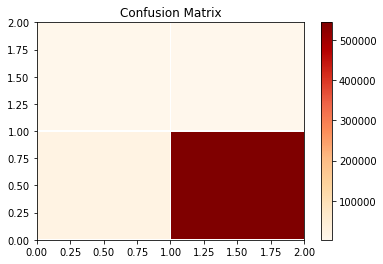

In [36]:
data = [[fp, tn], [tp, fn]]
print(data)
heatmap = plt.pcolor(data, cmap="OrRd", ec='white')
plt.colorbar(heatmap)
# annot=True,cmap="OrRd"
plt.title("Confusion Matrix")
plt.show()

In [37]:
precision_score(actual_rating_list, pred_rating_list, pos_label='positive')

0.2508560655611558

In [38]:
recall_score(actual_rating_list, pred_rating_list, pos_label='positive')

0.7225177304964538

In [39]:
f1_score(actual_rating_list, pred_rating_list, pos_label='positive')

0.3724118235042125